In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2024-04-22 08:33:15--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-04-22 08:33:16 ERROR 403: Forbidden.



In [67]:
df = pd.read_csv('/content/drive/MyDrive/PyTorch Projects/spam.csv', encoding='ISO-8859-1')

In [68]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [69]:
#drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [70]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [71]:
#rename columns
df.columns = ['labels', 'data']

In [72]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [73]:
#creating binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [74]:
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [75]:
df_train, df_test = train_test_split(df, test_size=.33)

In [76]:
df_train.shape, df_test.shape

((3733, 3), (1839, 3))

In [77]:
# 0 = padding
idx = 1
word2idx = {'<PAD>': 0}

In [78]:
#tokenization
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  for token in tokens:
    if token not in word2idx:
      word2idx[token] = idx
      idx+=1

In [79]:
word2idx

{'<PAD>': 0,
 'better.': 1,
 'made': 2,
 'up': 3,
 'for': 4,
 'friday': 5,
 'and': 6,
 'stuffed': 7,
 'myself': 8,
 'like': 9,
 'a': 10,
 'pig': 11,
 'yesterday.': 12,
 'now': 13,
 'i': 14,
 'feel': 15,
 'bleh.': 16,
 'but': 17,
 'at': 18,
 'least': 19,
 'its': 20,
 'not': 21,
 'writhing': 22,
 'pain': 23,
 'kind': 24,
 'of': 25,
 'gain': 26,
 'the': 27,
 'rights': 28,
 'wife.dont': 29,
 'demand': 30,
 'it.i': 31,
 'am': 32,
 'trying': 33,
 'as': 34,
 'husband': 35,
 'too.lets': 36,
 'see': 37,
 'happy': 38,
 'or': 39,
 'sad': 40,
 ',': 41,
 'one': 42,
 'thing': 43,
 'about': 44,
 'past': 45,
 'is-': 46,
 '\\its': 47,
 'no': 48,
 'more\\"': 49,
 'good': 50,
 'morning': 51,
 ':-):-)."': 52,
 'have': 53,
 'evening!': 54,
 'ttyl': 55,
 'dunno': 56,
 'juz': 57,
 'askin': 58,
 'cos': 59,
 'got': 60,
 'card': 61,
 '20%': 62,
 'off': 63,
 '4': 64,
 'salon': 65,
 'called': 66,
 'hair': 67,
 'sense': 68,
 'so': 69,
 'tot': 70,
 "it's": 71,
 'da': 72,
 'ì_': 73,
 'cut': 74,
 'ur': 75,
 'hair.': 

In [80]:
len(word2idx)

10524

In [81]:
#covert data into word indices
train_sentences_as_int = []
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens]
  train_sentences_as_int.append(sentence_as_int)

In [82]:
test_sentences_as_int = []
for i, row in df_test.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
  test_sentences_as_int.append(sentence_as_int)

In [83]:
len(train_sentences_as_int), len(test_sentences_as_int)

(3733, 1839)

In [84]:
def data_generator(X, y, batch_size = 32):
  X, y = shuffle(X, y)
  n_batches = int(np.ceil(len(y)/ batch_size))
  for i in range(n_batches):
    end = min((i + 1) * batch_size, len(y))

    X_batch = X[i * batch_size : end]
    y_batch = y[i * batch_size : end]

    #pad X_batch to be N x T
    max_len = np.max([len(x) for x in X_batch])
    for j in range(len(X_batch)):
      x = X_batch[j]
      pad = [0] * (max_len - len(x))
      X_batch[j] = pad + x

    #convert to tensor
    X_batch = torch.from_numpy(np.array(X_batch)).long()
    y_batch = torch.from_numpy(np.array(y_batch)).long()

    yield X_batch, y_batch

In [85]:
# N * T * D
embed = nn.Embedding(len(word2idx), 20)
for inputs, targets in data_generator(train_sentences_as_int, df_train.b_labels):
  out = embed(inputs)
  print("inputs:", inputs, "shape:", inputs.shape)
  print("output:", out, "shape:", out.shape)
  break

inputs: tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,   351],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           207,   199,   293,   372,   373,   106,   374,     4,   375],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           193,  1137,    10,  4003,   637,   915,    80,  4004,   910],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   647,  7072,    21,   839,   402,   467,
           928,   274,  7073,    37,   182,  1310,   377,  6640,  1452],
        [    0,     0,     0,     0,     0,     0,     0,     0,    

In [86]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [87]:
#Define the model
class CNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_outputs):
    super(CNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs

    self.embed = nn.Embedding(self.V, self.D)
    self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1)
    self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
    self.pool2 = nn.MaxPool1d(2)
    self.conv3 = nn.Conv1d(64, 128, 3, padding=1)

    self.fc = nn.Linear(128, self.K)

  def forward(self, X):

    #embedding layer
    out = self.embed(X)

    #note: output of embedding is always
    # (N, T, D)
    # (N, D, T) conv1d expects

    #conv layers
    out = out.permute(0, 2, 1)
    out = self.conv1(out)
    out = F.relu(out)
    out = self.pool1(out)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.pool2(out)
    out = self.conv3(out)
    out = F.relu(out)

    #change it back
    out = out.permute(0, 2, 1)

    #max pool
    out, _ = torch.max(out, 1)

    #final dense layer
    out = self.fc(out)
    return out



In [88]:
model = CNN(len(word2idx), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(10524, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [89]:
#Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [90]:
train_gen = lambda : data_generator(train_sentences_as_int, df_train.b_labels)
test_gen = lambda : data_generator(test_sentences_as_int, df_test.b_labels)

In [91]:
# A function to encapsualte the training loop
def  batch_gd(model, criterion, optimizer, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_gen():
      targets = targets.view(-1, 1).float()
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_gen():
      inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    #Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss: .4f}, \
    Test Loss: {test_loss: .4f}, Duration: {dt}')
  return train_losses, test_losses

In [92]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, 8)

Epoch 1/8, Train Loss:  0.3773,     Test Loss:  0.2999, Duration: 0:00:00.638379
Epoch 2/8, Train Loss:  0.2354,     Test Loss:  0.1779, Duration: 0:00:00.632195
Epoch 3/8, Train Loss:  0.1487,     Test Loss:  0.1396, Duration: 0:00:00.617135
Epoch 4/8, Train Loss:  0.1072,     Test Loss:  0.1353, Duration: 0:00:00.641428
Epoch 5/8, Train Loss:  0.0837,     Test Loss:  0.1177, Duration: 0:00:00.661581
Epoch 6/8, Train Loss:  0.0568,     Test Loss:  0.1123, Duration: 0:00:00.466132
Epoch 7/8, Train Loss:  0.0413,     Test Loss:  0.1119, Duration: 0:00:00.491769
Epoch 8/8, Train Loss:  0.0305,     Test Loss:  0.1015, Duration: 0:00:00.475854


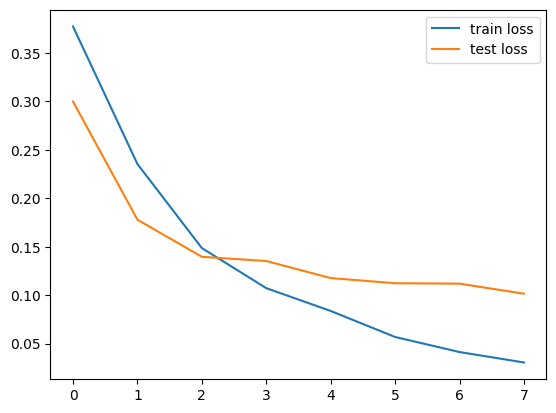

In [93]:
#Plot the train loss  and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [94]:
# Accuracy
n_correct = 0.
n_total = 0.
for inputs, targets in train_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  outputs  = model(inputs)

  predictions = (outputs > 0)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  outputs  = model(inputs)

  predictions = (outputs > 0)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.9946, Test acc: 0.9761
